In [1]:
import pickle
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


from tools import kobak_tsne, log_transform, PCA_sklearn, pearson_residuals, prepare_largest_batch, run_glmpca, sqrt_lazy, normalize_and_scale, pickle_sanity_results

# Compute normalization

In [2]:
title_fontsize = 20
title_fontweight = "bold"

# Scanpy colors (originally from http://godsnotwheregodsnot.blogspot.com/2013/11/kmeans-color-quantization-seeding.html)
cmap_colors = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]

excluded_color_ids = [0,7,17,31,41,45,50,88,96,105] #excluded for low contrast on white
cmap_colors = [c for i,c in enumerate(cmap_colors) if not i in excluded_color_ids]

#### Load datasets

In [3]:
files =['datasets/retina/macosko_all/GSE63472_P14Retina_merged_digital_expression.txt_preprocessed.pickle',
        'datasets/retina/shekhar_bipolar/GSE81904_BipolarUMICounts_Cell2016.txt.gz_preprocessed.pickle',
        'datasets/retina/tran_ganglion/GSE133382_AtlasRGCs_CountMatrix.csv_preprocessed.pickle']

labels = ['macosko',
          'shekhar_bipolar',
          'tran_ganglion']

datasets=[]
for file,label in zip(files,labels):
    with open(file, "rb") as f:
        dataset = pickle.load(f)
        dataset['labelshort'] = label
    
    
    if label in ['macosko','shekhar_bipolar']:
        prepare_largest_batch(dataset,extra_keys=['replicates'])
    else:
        prepare_largest_batch(dataset)
    
    n_clusters = len(np.unique(dataset['clusters']))
    dataset['cmap']=ListedColormap(cmap_colors[:n_clusters])
    dataset['gene_means'] = np.array(np.mean(dataset['counts'],axis=0)).flatten()
    dataset['depths'] = np.array(np.sum(dataset['counts'],axis=1)).flatten() 
    
    datasets.append(dataset)

Of 19252 total genes, returning 17973 genes that are detected in 5 or more cells.
Output shape: (24769, 17973)
Of 18149 total genes, returning 16520 genes that are detected in 5 or more cells.
Output shape: (13987, 16520)
Of 18137 total genes, returning 17685 genes that are detected in 5 or more cells.
Output shape: (15750, 17685)


## Save data as textfile

In [4]:
# # # ### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
for i,data in enumerate(datasets):
    filename = '/'.join(files[i].split('/')[:-1])+'/sanity_export_TRANSPOSED.mtx'
    print(filename)
    with open(filename,'wb') as f:
        io.mmwrite(f,data['counts'].T)

## Run Sanity

After you executed the previous cells, you have to run sanity on it. To reproduce our code, we recommend you take the following steps:

- Install Sanity, following the instructions from the authors' [github](https://github.com/jmbreda/Sanity). Note that we used version [1.1.2](https://github.com/jmbreda/Sanity/releases/tag/v1.1.2).
- open a terminal and `cd` to `umi-normalization/datasets/retina`
- run the following commands to run Sanity on the three retinal datasets with 10 CPUs:

```
/PATH/TO/SANTIY/bin/Sanity -n 10 -f tran_ganglion/sanity_export_TRANSPOSED.mtx -d tran_ganglion/sanity_output/
/PATH/TO/SANTIY/bin/Sanity -n 10 -f shekhar_bipolar/sanity_export_TRANSPOSED.mtx -d shekhar_bipolar/sanity_output/
/PATH/TO/SANTIY/bin/Sanity -n 10 -f macosko_all/sanity_export_TRANSPOSED.mtx -d macosko_all/sanity_output/
```

- continue with the next cells of this notebook


umi-normalization/datasets$ /PATH/TO/SANTIY/bin/Sanity -n 30 -f cao/sanity_export_TRANSPOSED.mtx -d cao/sanity_output/                              

### Pickle sanity results for faster subsequent loading

In [5]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
for i,dataset in enumerate(datasets):
    filename = '/'.join(files[i].split('/')[:-1])+'/sanity_output/log_transcription_quotients.txt'
    pickle_sanity_results(filename)

### Load pickled Sanity results and compute tSNE

In [6]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
## Load sanity pickle
for i,dataset in enumerate(datasets):
    filename = '/'.join(files[i].split('/')[:-1])+'/sanity_output/log_transcription_quotients.txt'
    with open(filename+'.pickle','rb') as f:
        dataset['sanity_ltqs'] = pickle.load(f)


## Compute shared tSNE init
for dataset in datasets:
    dataset['sqrt_lazy'] = sqrt_lazy(dataset['counts'].toarray())

## Compute tSNEs
for dataset in datasets:
    _,sqrt_lazy_init = PCA_sklearn(dataset['sqrt_lazy'],50,42)
    _ = kobak_tsne(dataset['sanity_ltqs'],name=dataset['labelshort']+'sanityLTQs_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)

### load tSNEs

In [7]:
for dataset in datasets:    
    with open('tsne/tsne_%s_sqrt_lazy_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['sqrt_lazy_tsne'] = pickle.load(f)  
    with open('tsne/tsne_%s_residuals_theta100_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['residuals_theta100_tsne'] = pickle.load(f)    
    with open('tsne/tsne_%s_glmpca-py_nb_thetaFixed100_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['glmpca-py_nb_thetaFixed100_tsne'] = pickle.load(f)
    with open('tsne/tsne_%ssanityLTQs_initsqrtLazy.pickle' % (dataset['labelshort']),'rb') as f:
        dataset['sanity_tsne'] = pickle.load(f)  

In [8]:
label_mapping_paper = {'shekhar_bipolar_largestBatch':'Bipolar cells\n(Shekhar et al. 2016)',
                        'tran_ganglion_largestBatch':'Ganglion cells\n(Tran et al. 2019)',
                        'macosko_largestBatch':'All retinal cell classes\n(Macosko et al. 2015)'}

### Extended Figure 3 with Sanity tSNE


In [9]:
title_fontsize = 20
title_fontweight = "bold"

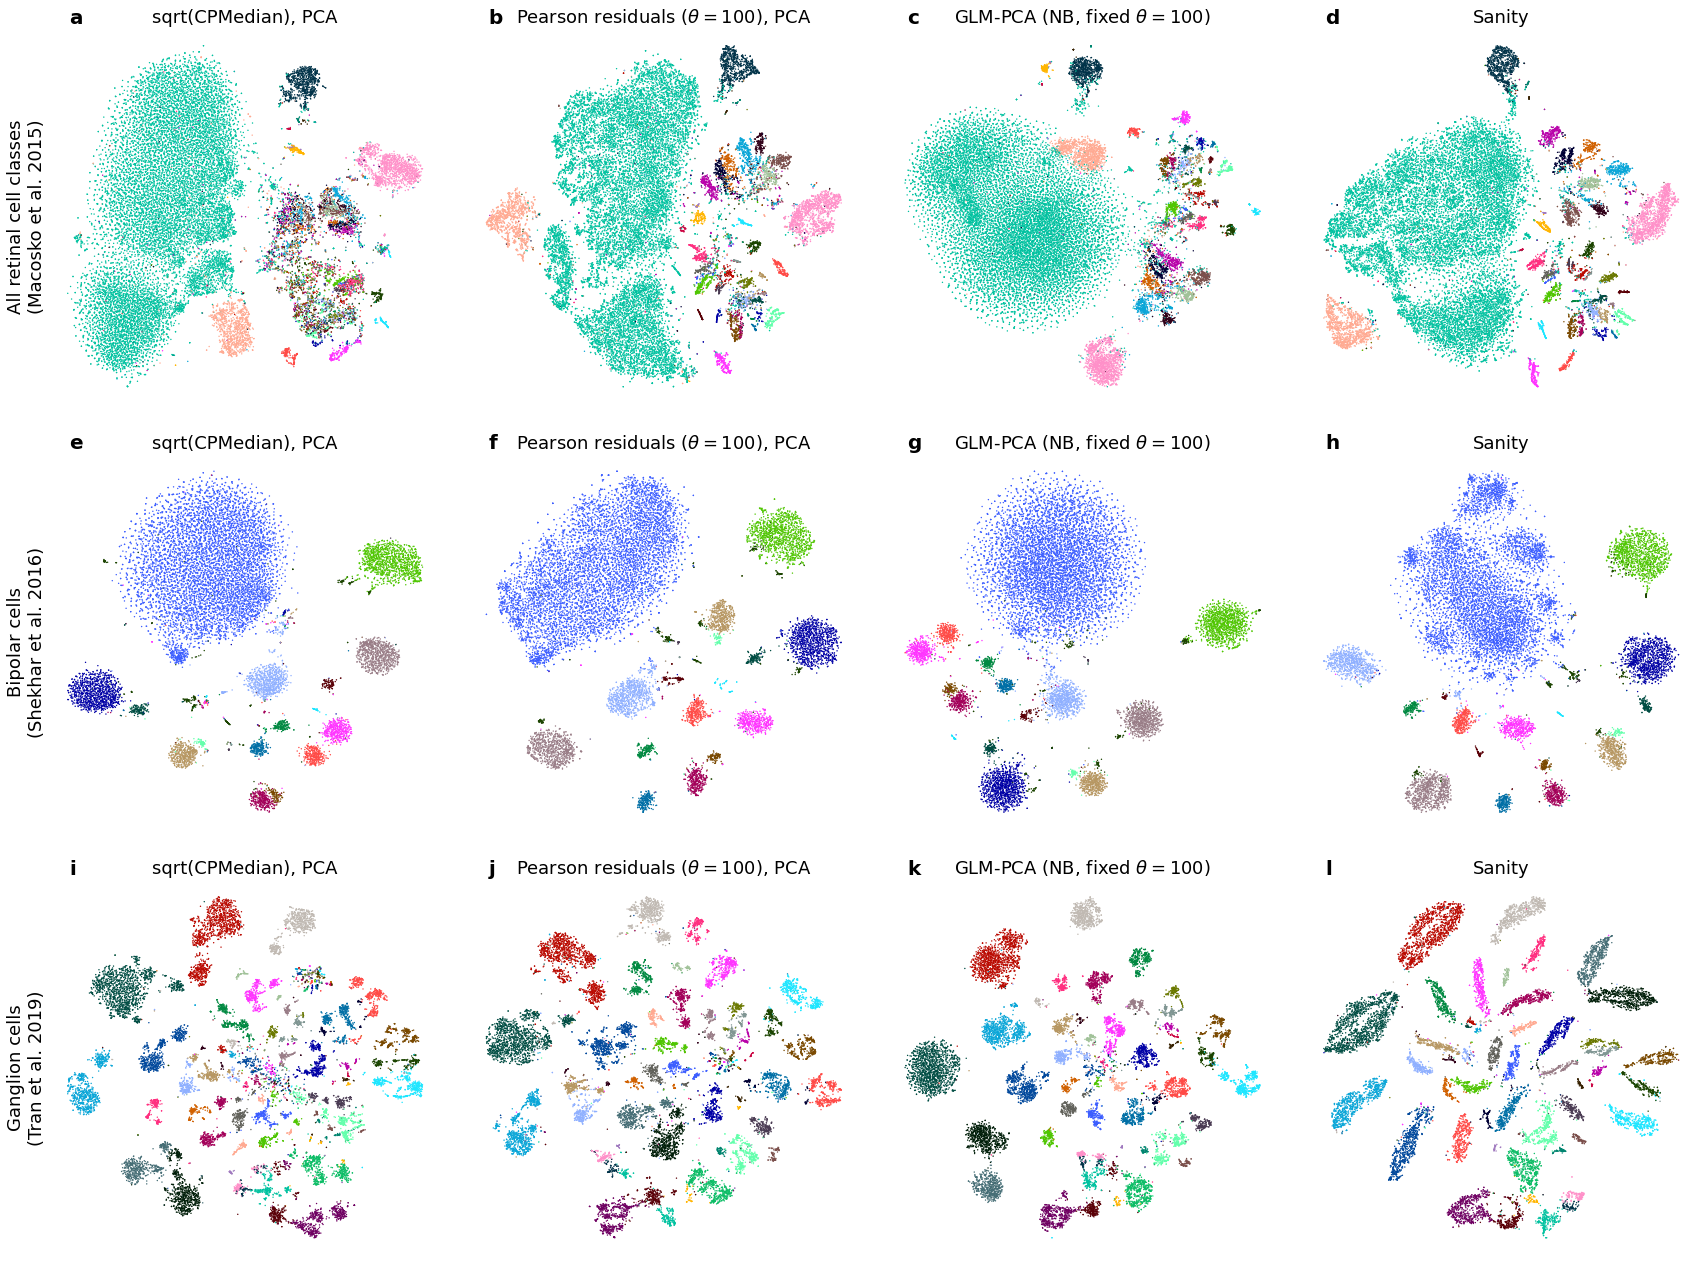

In [10]:
titles = ['sqrt(CPMedian), PCA', r'Pearson residuals ($\theta=100$), PCA',  r'GLM-PCA (NB, fixed $\theta=100$)', 'Sanity']
tsne_keys = ['sqrt_lazy_tsne',              'residuals_theta100_tsne',      'glmpca-py_nb_thetaFixed100_tsne',    'sanity_tsne']
letters = ['a','b','c','d',
           'e','f','g','h',
           'i','j','k','l']

with sns.plotting_context('talk'):


    fig,axes = plt.subplots(3,4,figsize=(24,18))
    i=0
    for dataset_id,dataset in enumerate(datasets[:3]):

        for method_id,(title,tsne_key) in enumerate(zip(titles,tsne_keys)):

            letter = letters[i]
            i+=1
            
            ax = axes[dataset_id,method_id]
            ax.set_title(title)
            ax.text(0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)

            points = ax.scatter(dataset[tsne_key]['coords'][:,0], dataset[tsne_key]['coords'][:,1], s=2, edgecolor='none',c=dataset['clusters'],cmap=dataset['cmap'], rasterized=True)

            ax.set_xticks([])
            ax.set_yticks([])
            if method_id==0:
                ax.set_ylabel(label_mapping_paper[dataset['labelshort']])
    plt.tight_layout()
    sns.despine(bottom=True,left=True)

In [11]:
%load_ext watermark

In [12]:
watermark

Last updated: 2021-07-31T19:37:58.824444+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [13]:
watermark --iversions

matplotlib: 3.3.3
scipy     : 1.6.0
seaborn   : 0.11.1
numpy     : 1.20.1

